/Users/qibinhuang/Library/Python/3.11/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Sample Month_Year from trends_df: ['2020-02' '2020-03' '2020-04' '2020-05' '2020-06']
✅ Sample Month_Year from target_df: ['2019-01' '2019-02' '2019-03' '2019-04' '2019-05']
✅ Number of common Month_Year values: 59
✅ Total rows after merge: 5344


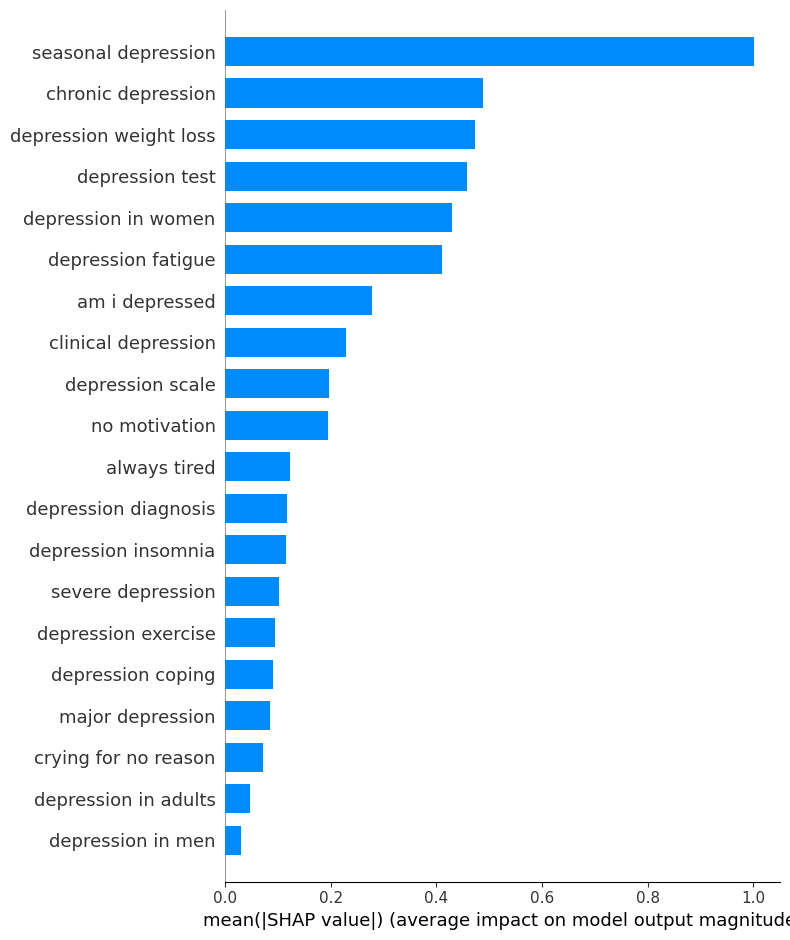

In [1]:
#%%
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

#%%
# Load data
trends_df = pd.read_csv("/Users/qibinhuang/Desktop/us_trends_monthly_cleaned.csv")
target_df = pd.read_csv("/Users/qibinhuang/Desktop/combined_depression_anxiety.csv")

#%%
# Preprocess Month_Year columns
trends_df["date"] = pd.to_datetime(trends_df["date"])
trends_df["Month_Year"] = trends_df["date"].dt.to_period("M").astype(str)

target_df["Month"] = target_df["Month"].astype(int).astype(str).str.zfill(2)
target_df["Year"] = target_df["Year"].astype(int).astype(str)
target_df["Month_Year"] = target_df["Year"] + "-" + target_df["Month"]

# Optional: check overlap
print("✅ Sample Month_Year from trends_df:", trends_df["Month_Year"].unique()[:5])
print("✅ Sample Month_Year from target_df:", target_df["Month_Year"].unique()[:5])
common = set(trends_df["Month_Year"]).intersection(set(target_df["Month_Year"]))
print("✅ Number of common Month_Year values:", len(common))

#%%
# Merge datasets
df = pd.merge(trends_df, target_df, on="Month_Year").dropna()
print("✅ Total rows after merge:", len(df))

#%%
# Define target and features
y = df["Combined_Value"]
X = df.drop(columns=[
    "date", "Month", "Year", "State", "Indicated", "Month_Year", "Combined_Value"
])

#%%
# Split with fallback for small datasets
total_rows = len(df)
if total_rows < 5:
    print("⚠️ Not enough data to split. Using full data for training & SHAP.")
    X_train, X_test = X, X
    y_train, y_test = y, y
else:
    split_idx = int(total_rows * 0.7)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

#%%
# Train model
model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=100,
    max_depth=3,
    random_state=42
)
model.fit(X_train, y_train)

#%%
# SHAP analysis
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Summary bar plot (top features)
shap.summary_plot(shap_values, X_test, plot_type="bar")

## SHAP Feature Importance Summary

### The SHAP summary plot shows the average impact of each search term on the model’s output—i.e., how much each feature contributes to increasing or decreasing the predicted depression/anxiety score.

## Key findings include:
###	•	“seasonal depression” had the highest impact on model predictions. This suggests that seasonal search behavior strongly correlates with population-level mental health scores, possibly reflecting known patterns like Seasonal Affective Disorder (SAD).
### •	Other high-impact terms include:
###	•	“chronic depression”, “depression weight loss”, and “depression fatigue”,
all of which reflect more clinical or physical dimensions of depression.
###	•	Gendered terms like “depression in women” appeared more influential than “depression in men”, indicating possible gendered patterns in search behavior or condition visibility.
###	•	Less impactful but still relevant terms such as “crying for no reason” and “no motivation” suggest emotional expressions have a smaller but non-negligible role in the model.


## Possible interpretation:

### This model prioritizes search terms that point toward clinical diagnosis, chronicity, or physical symptoms of depression rather than vague or one-off emotional expressions. It suggests that search behaviors involving long-term or medically-framed depression experiences are more predictive of population-level mental health scores.
